## Image Classifier using CNN

This project shows how to build an image classifier of your choice based on dataset of images you provide.
<br>We will use Convolutional Neural Networks (CNN) this time

In [ ]:
#install a required library to use OSC protocol
!pip install https://github.com/attwad/python-osc/archive/master.zip
!pip install matplotlib
!conda install scikit-learn -y

This function, __load_dataset_from_folder__, will load image files from specific path. It will return an array of samples with their assigned label, and a list of labels.
<br>An example of dataset folder structure is the following:
<br>__Shoes__
<br>|-__children__
<br>|----|- imgA.jpg
<br>|----|- imgB.jpg
<br>|----| ....
<br>|----|- imgN.jpg
<br>|-__men__
<br>|----|- imgA.jpg
<br>|----|- imgB.jpg
<br>|----| ....
<br>|----|- imgN.jpg
<br>|-__women__
<br>|----|- imgA.jpg
<br>|----|- imgB.jpg
<br>|----| ....
<br>|----|- imgN.jpg

This will generate a dataset for shoes with labels: 
<br>children: 0
<br>men     :1
<br>women :2

In [73]:
import numpy as np
import PML

TARGET_WIDTH=64
TARGET_HEIGHT=64

print("Loading Training Samples...")
samples,labels=PML.load_img_dataset_from_folder("datasets/catsdogs",target_size=(TARGET_WIDTH,TARGET_HEIGHT))

for i,l in enumerate(labels):
    samples_count=len([s for s in samples if s[1]==i])
    print("{0}- [{1}] with total of {2} samples".format(i,l,samples_count))
    

#load test samples
print("Loading Test Samples...")
sample_test,labels_test=PML.load_img_dataset_from_folder("test/catsdogs/",target_size=(TARGET_WIDTH,TARGET_HEIGHT))
for i,l in enumerate(labels_test):
    samples_count=len([s for s in sample_test if s[1]==i])
    print("{0}- [{1}] with total of {2} samples".format(i,l,samples_count))
    

Loading Training Samples...
0- [dogs] with total of 4005 samples
1- [cats] with total of 4000 samples
Loading Test Samples...
0- [dogs] with total of 4005 samples
1- [cats] with total of 4000 samples


Show some random images from the loaded dataset

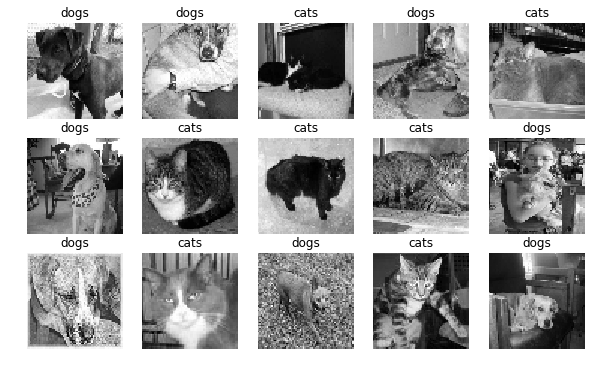

In [59]:

import PML
%matplotlib inline
PML.random_plot_images(samples,labels=labels,rows=3,cols=5)

## Preprocessing

Reshape the loaded samples to a 1D vector so it can be used in the neural network, and normalize image values.

Convert the labels from numbers to one-hot-encoding

In [61]:

from tensorflow.keras import utils
import random
from importlib import reload
reload(PML)

#shuffle samples order
random.shuffle(samples)

#Split to input X and labels Y
X=np.array([i[0] for i in samples])
Y=np.array([i[1] for i in samples])
 
#Prepared to convolutional samples (3 channels per sample)
X=PML.prepare_conv_samples(X)#.astype('float')
#normalize values
x_train,normalizer=PML.normalize_0_1(X)

#prepare labels to one-hot-encoding
nb_classes=len(labels)
y_train = utils.to_categorical(Y, nb_classes)

In [63]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.1)

print("Training using: {0} samples".format(len(X_train)))
print("Validating using: {0} samples".format(len(X_test)))

Training using: 1969 samples
Validating using: 219 samples


## Model Creation

Create a model for training

In [67]:

from tensorflow.keras.callbacks import TensorBoard
from time import time

#prepare tensorboard
tensorboard = TensorBoard(log_dir="logs/Images_{}".format(time()))

TrainModel=True #Set to False to load pretrained model

X_train=np.array(X_train)
X_test=np.array(X_test)

Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

model=PML.create_conv_classify_model(X_train.shape[1:],nb_classes,32,[32,64,64],64,dropout=0)
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=20,batch_size=128, callbacks=[tensorboard])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 64)          36928     
__________

In [68]:
from importlib import reload
reload(PML)

PML.export_model(model,"./saved_models/catsdogs")

Model exported.


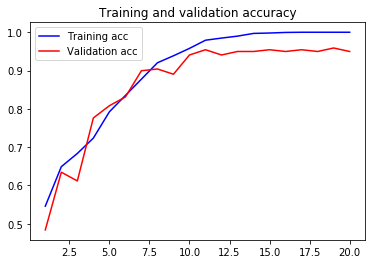

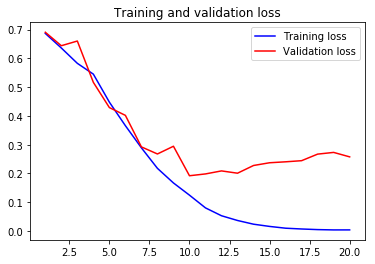

In [69]:
PML.plot_acc_loss(history)

## Test Samples

Load newly unseen samples to test them against the trained model. Check the accuracy of training.

In [72]:
import importlib
importlib.reload(PML)
_=PML.test_samples(model,samples=sample_test,labels=labels,normalizer=normalizer,flatten=False)

Accuracy for [dogs] is 75%
Accuracy for [cats] is 53%


## [Optional] OSC for realtime recognition


You can use this to communicate with external application (Processing for example) to predict images

In [ ]:
#setup OSC Protocol to communicate with Processing
import OSCHelper
server=OSCHelper.createServer(9000)
client=OSCHelper.createClient(4200)

In [ ]:
import numpy as np
import io

def onOSC_Image(*args):
    width=args[1]
    height=args[2]
    jpgdata=args[3]
    file_jpgdata = io.BytesIO(jpgdata)
    img = Image.open(file_jpgdata).resize((TARGET_WIDTH,TARGET_HEIGHT)).convert("L")
    img=np.array(img).astype(float)
    img=(img-mean)/std
    x=np.reshape(img,(TARGET_WIDTH*TARGET_HEIGHT))
    res=model.predict(np.array([x]))
    label_idx=np.argmax(res)
    client.send_message("/output/label",[int(label_idx),str(labels[label_idx])])
    #plt.imshow(img,cmap='gray')
    #plt.title("Prediction:{0}".format(labels[label_idx]))
    #plt.show()

server.addMsgHandler( "/inputs/image", onOSC_Image )

OSCHelper.start_server(server)


In [ ]:
server.close()
